In [9]:
import numpy as np
import pandas as pd
import torch
from typing import Optional, Literal, Union
import matplotlib.pyplot as plt

# we use a local copy of the fast_soft_sort manually downloaded from
# https://github.com/google-research/fast-soft-sort/tree/master
from fast_soft_sort.pytorch_ops import soft_rank

## Test ordinary lr in torch

Data generating model and data:

In [2]:
n_features = 3
n_samples = 1000

torch.manual_seed(0)

model_true = torch.nn.Linear(n_features, 1)

with torch.no_grad():
    i = 1
    for name, param in model_true.named_parameters():
        param.copy_(torch.arange(i, i + param.numel()))
        i += param.numel()
        param.requires_grad = False

for name, param in model_true.named_parameters():
    print(name, param)

X_train = torch.rand((n_samples, n_features))
y_train = model_true(X_train)

X_test = torch.rand((n_samples // 10, n_features))
y_test = model_true(X_test)

weight Parameter containing:
tensor([[1., 2., 3.]])
bias Parameter containing:
tensor([4.])


Model to train:

In [ ]:
model = torch.nn.Linear(n_features, 1)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.0)

def loss_fn(y, y_hat):
    criterion = torch.nn.MSELoss()
    return criterion(y, y_hat)
    return torch.norm(y - y_hat) / np.sqrt(len(y))

Help func:

In [ ]:
def train_step(X, y, model, loss_fn, optimizer):
    # Compute prediction and loss
    y_hat = model(X)
    loss = loss_fn(y, y_hat)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # did not forget!

    return loss

Train:

In [ ]:
stats = {"training loss": [], "test loss": []}
for epoch in range(10000):
    train_loss = train_step(X_train, y_train, model, loss_fn, optimizer)
    test_loss = loss_fn(y_test, model(X_test))
    stats["training loss"].append(train_loss.item())
    stats["test loss"].append(test_loss.item())

In [ ]:
pd.DataFrame(stats).plot()

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}:\t{param}")

## Soft rank

In [3]:
model = torch.nn.Linear(n_features, 1)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.0)

regularization_strength = 1.0

def loss_fn(y, y_hat):
    # rank true values
    r = torch.empty_like(y)
    r[y.argsort(dim=0), 0] = torch.arange(1, y.numel() + 1, dtype=y.dtype).reshape(-1, 1)
       
    # soft rank predictions
    r_hat = soft_rank(y_hat.reshape(1, -1), regularization_strength=0.001).reshape(-1, 1)
    
    # normalize ranks
    r = (r - 1) / (r.numel() - 1)
    r_hat = (r_hat - 1) / (r_hat.numel() - 1)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" 
    # article)
    criterion = torch.nn.MSELoss()
    loss = criterion(r, r_hat)

    return loss

def eval_fn(y, y_hat):
    # rank true values
    r = torch.empty_like(y)
    r[y.argsort(dim=0), 0] = torch.arange(1, y.numel() + 1, dtype=y.dtype).reshape(-1, 1)
       
    # soft rank predictions
    r_hat = torch.empty_like(y_hat)
    r_hat[y_hat.argsort(dim=0), 0] = torch.arange(1, y_hat.numel() + 1, dtype=y_hat.dtype).reshape(-1, 1)
    
    # normalize ranks
    r = (r - 1) / (r.numel() - 1)
    r_hat = (r_hat - 1) / (r_hat.numel() - 1)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" 
    # article)
    criterion = torch.nn.MSELoss()
    loss = criterion(r, r_hat)

    return loss

In [4]:
def train_step(X, y, model, loss_fn, optimizer):   
    # Compute prediction and loss
    y_hat = model(X)
    loss = loss_fn(y, y_hat)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # did not forget!

    return loss

In [5]:
stats = {"training loss": [], "test loss": [], "training eval": [], "test eval": []}
for epoch in range(2000):
    train_loss = train_step(X_train, y_train, model, loss_fn, optimizer)
    test_loss = loss_fn(y_test, model(X_test))
    
    # evaluation (exact ranks)
    train_eval = eval_fn(y_train, model(X_train))
    test_eval = eval_fn(y_test, model(X_test))
    
    stats["training loss"].append(train_loss.item())
    stats["test loss"].append(test_loss.item())
    stats["training eval"].append(train_eval.item())
    stats["test eval"].append(test_eval.item())

<Axes: >

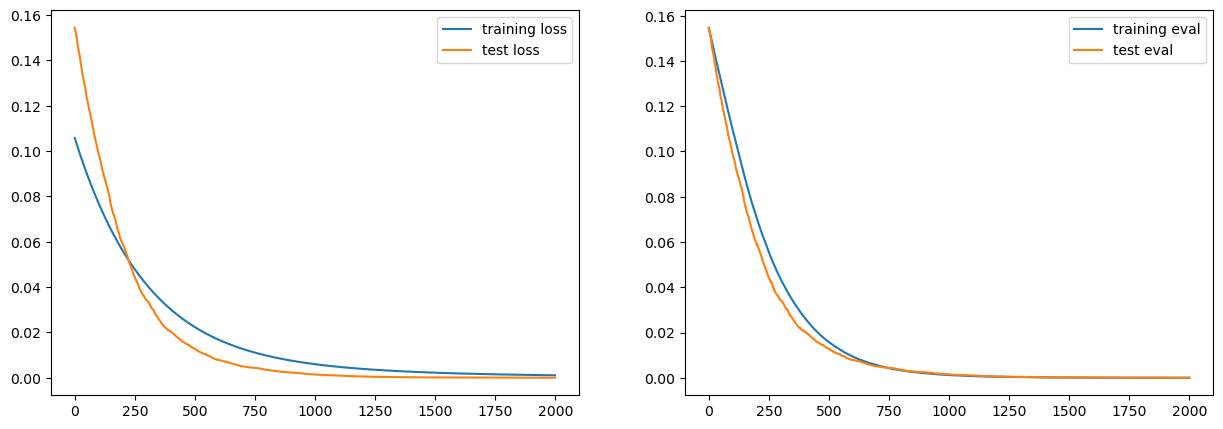

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
pd.DataFrame(stats).iloc[:, :2].plot(ax=axs[0])
pd.DataFrame(stats).iloc[:, 2:].plot(ax=axs[1])

In [8]:
pd.DataFrame(stats)

,training loss,test loss,training eval,test eval
0,0.105793,0.154388,0.154610,0.154492
1,0.105454,0.153910,0.154132,0.153901
2,0.105115,0.153498,0.153665,0.153382
3,0.104778,0.153119,0.153238,0.153076
4,0.104442,0.152431,0.152795,0.152566
...,...,...,...,...
1995,0.001118,0.000023,0.000003,0.000022
1996,0.001117,0.000023,0.000003,0.000022
1997,0.001115,0.000023,0.000003,0.000022
1998,0.001114,0.000023,0.000003,0.000022


In [7]:
for name, param in model.named_parameters():
    print(f"{name}:\t{param}")

weight:	Parameter containing:
tensor([[0.2649, 0.5397, 0.8061]], requires_grad=True)
bias:	Parameter containing:
tensor([0.0546], requires_grad=True)


In [15]:
def rank(y):
    # rank true values
    r = torch.empty_like(y)
    r[y.argsort(dim=0), 0] = torch.arange(1, y.numel() + 1, dtype=y.dtype).reshape(-1, 1)
    return r

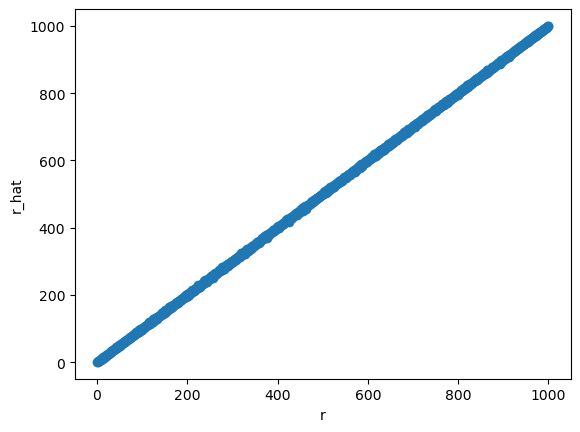

In [22]:
r = rank(y_train)
r_hat = rank(model(X_train))

fig, axs = plt.subplots()
axs.scatter(r, r_hat)
axs.set_xlabel("r")
axs.set_ylabel("r_hat")
plt.show()